In [23]:
import numpy as np 
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.optim as optim

from data_generation import generate_data
from models import OneHiddenRelu, SpikyModel, DeepRelu
from trainer import train_neural_model

L'objectif de cette expérience est de vérifier la consistance de la prédiction d'un réseau de neurones à une couche cachée très large avec la fonction d'activation spiky-smooth. 

Pour cela, nous allons créer 10 datasets chacun composé de couples $(X_i, Y_i)$ toujours tiré selon la même méthode. Les $X_i$ sont tirés selon une loi uniforme sur $[0, 1]$ et les $Y_i = cos(2 \pi \omega X_i) + N(0, \sigma^2)$. 

Ainsi, pour ces 10 datasets, nous allons estimer la variance et la MSE. 

A travers notre expérience, l'objectif est de voir si les objectifs de "benign overfitting" sont atteints. En effet, si le modèle peut overfit le bruit mais effectuer des prédictions en se "débarassant" du bruit, nous pourrons parler d'un overfitting bénin. Pour cela, nous nous attendons à observer très faible de notre estimateur. 

# Paramètres de l'expérience

In [24]:
n_datasets = 20  # nb of datasets to generate
n_points = 12  # nb of training data points
omega = 1.5 
deterministic = True
noise_scale = .5
n_test_points = 50  # nb of test data points 
hidden_size = 2000  # size of hidden layer of spiky model
freq = 400  # freq of spiky-smooth actvation function 
num_epochs = 4000

# Generation des données 

In [25]:
# make a generator of datasets
def data_generator(n_points=n_points, n_datasets=n_datasets):
    for _ in range(n_datasets):
        yield generate_data(n_points, 
                            noise_scale=noise_scale, 
                            deterministic=deterministic, 
                            freq=omega)

# Experiments 

In [26]:
# define testing points 
testing_points = np.linspace(0, 1, n_test_points).reshape(n_test_points, 1)
X_test = torch.tensor(testing_points, dtype=torch.float32)

# store value on testing points
relu_pred = np.zeros((n_datasets, n_test_points), dtype=np.float32)
spiky_pred = np.zeros((n_datasets, n_test_points), dtype=np.float32)

In [27]:
i = 0
for data in data_generator():

    # get data 
    X, y = data

    # define models
    relu_model = OneHiddenRelu(X.shape[-1], hidden_size=1000)
    spiky_model = SpikyModel(freq=freq, 
                             input_size=X.shape[-1], 
                             hidden_size=hidden_size, 
                             output_size=1)
    
    # train models 
    relu_model = train_neural_model(relu_model, X, y, num_epochs=num_epochs)
    spiky_model = train_neural_model(spiky_model, X, y, num_epochs=num_epochs)

    # make predictions 
    relu_pred[i, :] = relu_model(X_test).detach().numpy().T[0]
    spiky_pred[i, :] = spiky_model.inference(X_test).detach().numpy().T[0]

    # update 
    i += 1
    print(f"{i}/{n_datasets} iterations done.")


1/20 iterations done.
2/20 iterations done.
3/20 iterations done.
4/20 iterations done.
5/20 iterations done.
6/20 iterations done.
7/20 iterations done.
8/20 iterations done.
9/20 iterations done.
10/20 iterations done.
11/20 iterations done.
12/20 iterations done.
13/20 iterations done.
14/20 iterations done.
15/20 iterations done.
16/20 iterations done.
17/20 iterations done.
18/20 iterations done.
19/20 iterations done.
20/20 iterations done.


Nous pouvons maintenant évaluer la moyenne et la variance de chacune des deux méthodes en tous les points du dataset.

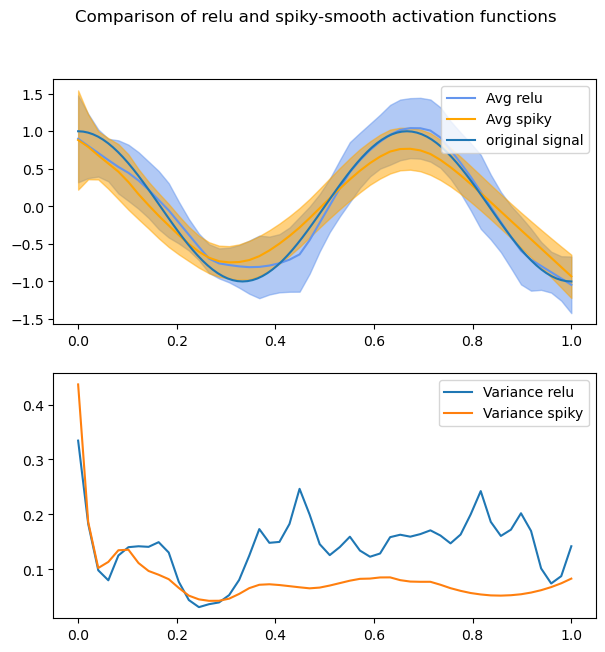

In [31]:
# compute mean at each point 
mean_relu = np.mean(relu_pred, axis=0)
mean_spiky = np.mean(spiky_pred, axis=0)

# compute variance at each point 
var_relu = np.var(relu_pred, axis=0)
var_spiky = np.var(spiky_pred, axis=0)

# add std on plot 
mean_relu_error_0 = mean_relu - np.sqrt(var_relu)
mean_relu_error_1 = mean_relu + np.sqrt(var_relu)
mean_spiky_error_0 = mean_spiky - np.sqrt(var_spiky)
mean_spiky_error_1 = mean_spiky + np.sqrt(var_spiky)

# construct theoretical signal 
x_ = np.linspace(0, 1., 100)
y_ = np.cos(x_ * 2 * omega * np.pi)

x = testing_points.reshape(len(testing_points))

# plot results 

fig, ax = plt.subplots(2, 1, figsize=(7, 7))

ax[0].plot(testing_points, mean_relu, color="cornflowerblue", label="Avg relu")
ax[0].fill_between(x, mean_relu_error_0, mean_relu_error_1, color='cornflowerblue', alpha=0.5)
ax[0].plot(testing_points, mean_spiky, color="orange", label="Avg spiky")
ax[0].fill_between(x, mean_spiky_error_0, mean_spiky_error_1, color='orange', alpha=0.5)
ax[0].plot(x_, y_, label="original signal")

ax[1].plot(testing_points, var_relu, label="Variance relu")
ax[1].plot(testing_points, var_spiky, label="Variance spiky")

fig.suptitle("Comparison of relu and spiky-smooth activation functions")

ax[0].legend()
ax[1].legend()

plt.show()

In [29]:
print(testing_points.reshape(len(testing_points)))

[0.         0.02040816 0.04081633 0.06122449 0.08163265 0.10204082
 0.12244898 0.14285714 0.16326531 0.18367347 0.20408163 0.2244898
 0.24489796 0.26530612 0.28571429 0.30612245 0.32653061 0.34693878
 0.36734694 0.3877551  0.40816327 0.42857143 0.44897959 0.46938776
 0.48979592 0.51020408 0.53061224 0.55102041 0.57142857 0.59183673
 0.6122449  0.63265306 0.65306122 0.67346939 0.69387755 0.71428571
 0.73469388 0.75510204 0.7755102  0.79591837 0.81632653 0.83673469
 0.85714286 0.87755102 0.89795918 0.91836735 0.93877551 0.95918367
 0.97959184 1.        ]


- Optimiser les paramètres
- Tracer les train loss et test loss 
- Tracer sur un même graphique l'incertitude / la variance pour se rendre compte